### (original) AIM: Extract features from EEG data and store in a singular dataframe

In [1]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper

%matplotlib inline

In [2]:
# prevent extensive logging
mne.set_log_level('WARNING')

In [3]:
# set folder containing participants data as working directory
participants_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data"
os.chdir(participants_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\TDBRAIN_participants_V2_data'

In [4]:
# load dataframe from pickle file created in previous notebook
df_par = pd.read_pickle('df_participants.pkl')
df_par.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1346
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   participants_ID  1347 non-null   string  
 1   DISC/REP         1347 non-null   category
 2   indication       1088 non-null   category
 3   formal_status    1323 non-null   category
 4   Dataset          365 non-null    category
 5   age              1326 non-null   float64 
 6   gender           1347 non-null   int32   
 7   sessID           1347 non-null   int32   
 8   nrSessions       1347 non-null   int32   
 9   EC               1347 non-null   bool    
 10  EO               1347 non-null   bool    
dtypes: bool(2), category(4), float64(1), int32(3), string(1)
memory usage: 55.9 KB


In [4]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


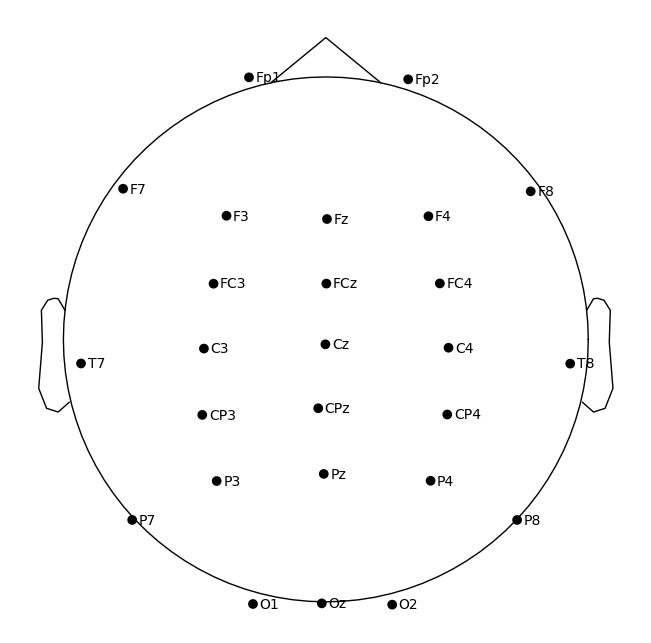

In [5]:
## Set montage and plot electrodes (Copied from Anne van Duijvenbode)

montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
mne.viz.plot_montage(montage = montage, scale_factor=10, show_names=True, show=True, sphere='eeglab')

montage.save('montage_eeg.fif', overwrite = True)

In [6]:
# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


### First calculating the PSD for a single participant, to test workflow

In [7]:
# first try for singular participant
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-19681349\ses-1\eeg\sub-19681349_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of column
eeg_data

raw = mne.io.RawArray(eeg_data, info)
raw.notch_filter(50)
raw.filter(0.5, 100)
raw.info


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,"26 EEG, 5 EOG, 1 ECG, 1 EMG"
Bad channels,None
EOG channels,"VPVA, VNVB, HPHL, HNHR, OrbOcc"
ECG channels,Erbs
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


''

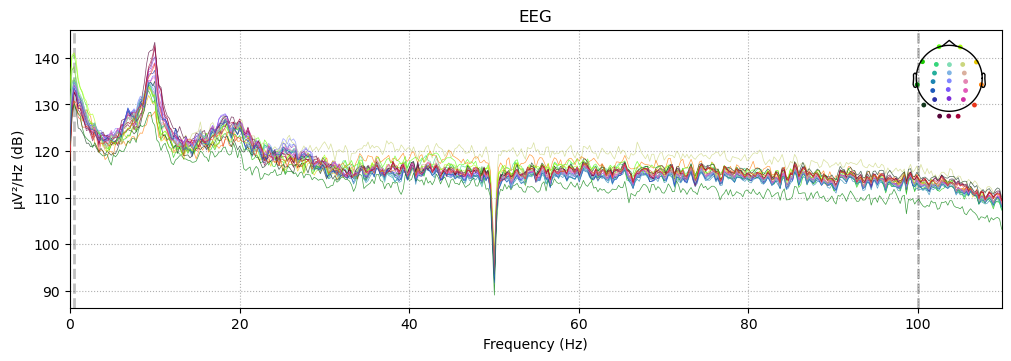

In [102]:
raw.compute_psd(fmax=110).plot(picks='data', exclude='bads')
;

In [103]:
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
psd_epochs = epochs.compute_psd(method = 'welch', fmin = 0.25, fmax = 110, picks = 'eeg', average = 'mean') # not sure which fmin and fmax to use?
psd_epochs_arr = psd_epochs.get_data(return_freqs=True) # tuple of (n epochs, n channels, n freqs)
#print(psd_epochs_arr)
#df_epoch = psd_epochs.to_data_frame(long_format=True)
print(psd_epochs)

<Power Spectrum (from Epochs, welch method) | 12 epochs × 26 channels × 449 freqs, 0.5-109.9 Hz>


In [104]:
# create pandas dataframe which holds the PSD as MNE Power Spectrum data type
df_test = pd.DataFrame({'ID' : [1, 2, 2, 3], 'ses' : [1, 1, 2, 1]})
df_test['PSDobj'] = ''
df_test['PSDobj'] = df_test['PSDobj'].astype('object')

df_test['PSDobj'] = df_test['PSDobj'].mask((df_test['ID']==2) & (df_test['ses'] == 1),pd.Series([psd_epochs]*df_test.shape[0]))

#df_test.loc[(df_test['ID']==2) & (df_test['ses'] == 1), 'PSDobj'] = [psd_epochs] # error

#df_test.loc[1, 'PSDobj'] = [psd_epochs] # needs to be stored as a list, otherwise error

#idx = df_test.index[(df_test['ID']==2) & (df_test['ses'] == 1)].tolist() # first get index
#df_test.at[idx[0], 'PSDobj'] = psd_epochs # could work, but .mask() seems more efficient

#print(pd.Series([psd_epochs]*df_test.shape[0]))
df_test

,ID,ses,PSDobj
0,1,1,
1,2,1,"<Power Spectrum (from Epochs, welch method) | ..."
2,2,2,
3,3,1,


In [64]:
def insert_psd(row):
    if row['ID'] == 2 and row['ses'] == 1:
        return psd_epochs
    else:
        return row['PSDobj']
df_test['PSDobj'] = df_test.apply(insert_psd, axis=1) # works, but not sure how efficient for when using in the loop for all participants
df_test

,ID,ses,PSDobj
0,1,1,
1,2,1,"<Power Spectrum (from Epochs, welch method) | ..."
2,2,2,
3,3,1,


In [70]:
# save to pickle/json and load from pickle/json
df_test.to_pickle('df_test.pkl')
df_test_pkl = pd.read_pickle('df_test.pkl')
df_test.to_json('df_test_json.json')
df_test_json = pd.read_json('df_test_json.json')

In [72]:
# check if Power Spectrum data type still hold all information after loading from pickle file
PSDobj = df_test_pkl.loc[1, 'PSDobj']
print(PSDobj)
print(PSDobj.get_data(return_freqs=True)) # still holds all information


<Power Spectrum (from Epochs, welch method) | 12 epochs × 26 channels × 449 freqs, 0.5-109.9 Hz>
(array([[[6.78270040e+01, 4.36183268e+01, 6.99512830e+00, ...,
         9.11607047e-02, 6.35177193e-02, 1.47553667e-01],
        [1.02827020e+02, 9.80377243e+01, 1.41822226e+00, ...,
         5.92275849e-02, 2.70670729e-02, 8.88666587e-02],
        [1.41726232e+01, 1.10973521e+01, 2.95126118e+01, ...,
         5.97822405e-02, 4.29549142e-02, 8.65667095e-02],
        ...,
        [2.85193730e+01, 3.19018999e+01, 3.87824631e+00, ...,
         6.83499156e-02, 3.67446791e-02, 1.95247080e-01],
        [1.84178157e+01, 3.54662904e+01, 2.88989684e+00, ...,
         7.49020644e-02, 4.36628452e-02, 1.79399868e-01],
        [3.53095307e+01, 5.02458432e+01, 3.28916360e+00, ...,
         6.23996479e-02, 4.29049554e-02, 1.77821008e-01]],

       [[7.48139646e+01, 4.44211019e+01, 1.61138795e+01, ...,
         4.25991335e-02, 1.63614124e-02, 7.32897145e-02],
        [8.38322581e+01, 7.64337275e+01, 3.7171

In [73]:
# check if Power Spectrum data type still hold all information after loading from json file
PSDobj = df_test_json.loc[1, 'PSDobj']
print(PSDobj)
#print(PSDobj[0].get_data(return_freqs=True)) # doesnt hold information as Power Spectrum data type, as it gets converted to dict

{'ch_names': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', 'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2'], 'compensation_grade': None, 'drop_log': [[], [], [], [], [], [], [], [], [], [], [], []], 'event_id': {'1': 1}, 'events': [[0, 0, 1], [5000, 0, 1], [10000, 0, 1], [15000, 0, 1], [20000, 0, 1], [25000, 0, 1], [30000, 0, 1], [35000, 0, 1], [40000, 0, 1], [45000, 0, 1], [50000, 0, 1], [55000, 0, 1]], 'freqs': [0.48828125, 0.732421875, 0.9765625, 1.220703125, 1.46484375, 1.708984375, 1.953125, 2.197265625, 2.44140625, 2.685546875, 2.9296875, 3.173828125, 3.41796875, 3.662109375, 3.90625, 4.150390625, 4.39453125, 4.638671875, 4.8828125, 5.126953125, 5.37109375, 5.615234375, 5.859375, 6.103515625, 6.34765625, 6.591796875, 6.8359375, 7.080078125, 7.32421875, 7.568359375, 7.8125, 8.056640625, 8.30078125, 8.544921875, 8.7890625, 9.033203125, 9.27734375, 9.521484375, 9.765625, 10.009765625, 10.25390625, 10.498046875, 10

### Now, use the workflow for a single participant to create loop for all participants

In [80]:
# add empty columns to the dataframe for EC/EO conditions in which the PSDs can be stored
df_par['EC_PSD'] = np.nan
df_par['EO_PSD'] = np.nan
df_par['EC_PSD'] = df_par['EC_PSD'].astype('object')
df_par['EO_PSD'] = df_par['EO_PSD'].astype('object')
df_par

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD
0,sub-19681349,REPLICATION,REPLICATION,REPLICATION,REPLICATION,51.59,0,1,1,True,True,NaN,NaN
1,sub-19681385,REPLICATION,REPLICATION,REPLICATION,REPLICATION,49.96,1,1,1,True,True,NaN,NaN
2,sub-19684666,REPLICATION,REPLICATION,REPLICATION,REPLICATION,47.05,1,1,1,True,True,NaN,NaN
3,sub-19686324,REPLICATION,REPLICATION,REPLICATION,REPLICATION,62.51,1,1,1,True,True,NaN,NaN
4,sub-19687321,REPLICATION,REPLICATION,REPLICATION,REPLICATION,53.98,1,1,2,True,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,sub-88078657,DISCOVERY,INSOMNIA,INSOMNIA,NaN,58.59,1,1,1,True,True,NaN,NaN
1343,sub-88078749,DISCOVERY,INSOMNIA,INSOMNIA,NaN,37.22,0,1,1,True,True,NaN,NaN
1344,sub-88078793,DISCOVERY,INSOMNIA,INSOMNIA,NaN,48.54,1,1,1,True,True,NaN,NaN
1345,sub-88078837,DISCOVERY,INSOMNIA,INSOMNIA,NaN,24.63,1,1,1,True,True,NaN,NaN


In [90]:
# calculate PSD for each EEG data .csv file and store in dataframe corresponding to participant and EC/EO condition
eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"
for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        #print(os.path.join(subdir, file))
        filepath = os.path.join(subdir, file)
        eeg_data = pd.read_csv(filepath, sep=',')
        eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

        raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
        raw.notch_filter(50)
        raw.filter(0.5, 100)
        #raw.info

        # epoch the data and compute PSD
        epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
        psd_epochs = epochs.compute_psd(method = 'welch', fmin = 0.25, fmax = 110, picks = 'eeg', average = 'mean') # not sure which fmin and fmax to use?
        
        # split file name to obtain ID and session number
        ID = str(file.split('_')[0])
        #print(ID)
        sessID = int(file.split('_')[1].split('-')[1])
        #print(sessID)
        
        # add Power Spectrum object to dataframe
        if 'EC' in file:
            df_par['EC_PSD'] = df_par['EC_PSD'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([psd_epochs]*df_par.shape[0]))
        if 'EO' in file:
            df_par['EO_PSD'] = df_par['EO_PSD'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([psd_epochs]*df_par.shape[0]))



df_par        

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD
0,sub-19681349,REPLICATION,REPLICATION,REPLICATION,REPLICATION,51.59,0,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1,sub-19681385,REPLICATION,REPLICATION,REPLICATION,REPLICATION,49.96,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
2,sub-19684666,REPLICATION,REPLICATION,REPLICATION,REPLICATION,47.05,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
3,sub-19686324,REPLICATION,REPLICATION,REPLICATION,REPLICATION,62.51,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
4,sub-19687321,REPLICATION,REPLICATION,REPLICATION,REPLICATION,53.98,1,1,2,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1342,sub-88078657,DISCOVERY,INSOMNIA,INSOMNIA,NaN,58.59,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1343,sub-88078749,DISCOVERY,INSOMNIA,INSOMNIA,NaN,37.22,0,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1344,sub-88078793,DISCOVERY,INSOMNIA,INSOMNIA,NaN,48.54,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1345,sub-88078837,DISCOVERY,INSOMNIA,INSOMNIA,NaN,24.63,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."


In [92]:
df_par.info() # two participants are missing PSD for EC and EO conditions

<class 'pandas.core.frame.DataFrame'>
Index: 1347 entries, 0 to 1346
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   participants_ID  1347 non-null   string  
 1   DISC/REP         1347 non-null   category
 2   indication       1088 non-null   category
 3   formal_status    1323 non-null   category
 4   Dataset          365 non-null    category
 5   age              1326 non-null   float64 
 6   gender           1347 non-null   int32   
 7   sessID           1347 non-null   int32   
 8   nrSessions       1347 non-null   int32   
 9   EC               1347 non-null   bool    
 10  EO               1347 non-null   bool    
 11  EC_PSD           1345 non-null   object  
 12  EO_PSD           1345 non-null   object  
dtypes: bool(2), category(4), float64(1), int32(3), object(2), string(1)
memory usage: 77.0+ KB


In [110]:
# find out which participants miss PSDs 
df_par[df_par['EC_PSD'].isna()]

# from looking at the files in the directories: both of these participants have the files of their second session missing (first session is still included)

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD
172,sub-87967869,DISCOVERY,SMC,UNKNOWN,NaN,57.31,1,2,2,True,True,NaN,NaN
273,sub-87980957,DISCOVERY,Dyslexia,Dyslexia,NaN,11.85,1,2,2,True,False,NaN,NaN


In [122]:
df_par.to_pickle('participants_PSD.pkl') # file of almost 3GB

In [8]:
# check if the saved pickle file correctly holds all PSD data
df_after_pickle = pd.read_pickle('participants_PSD.pkl')

In [124]:
psd_ec_1 = df_after_pickle.loc[0, 'EC_PSD']
psd_eo_1 = df_after_pickle.loc[0, 'EO_PSD']
psd_ec_2 = df_after_pickle.loc[100, 'EC_PSD']
psd_eo_2 = df_after_pickle.loc[100, 'EO_PSD']

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


''

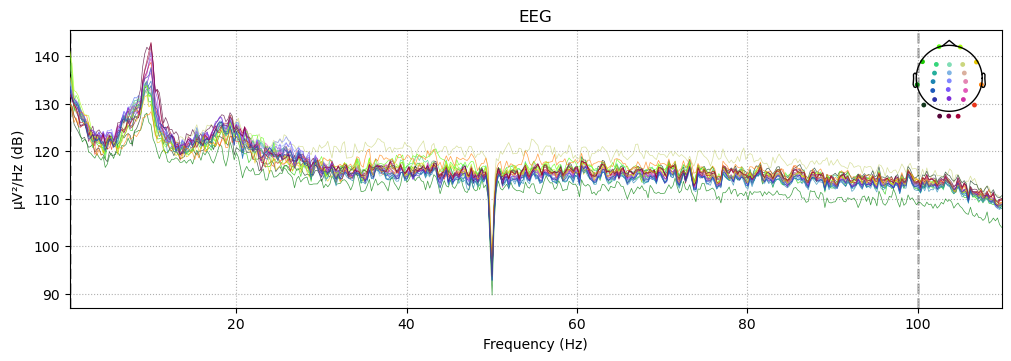

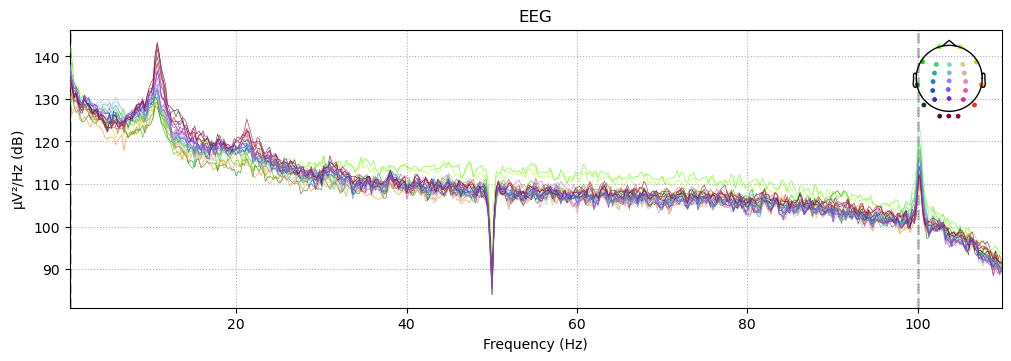

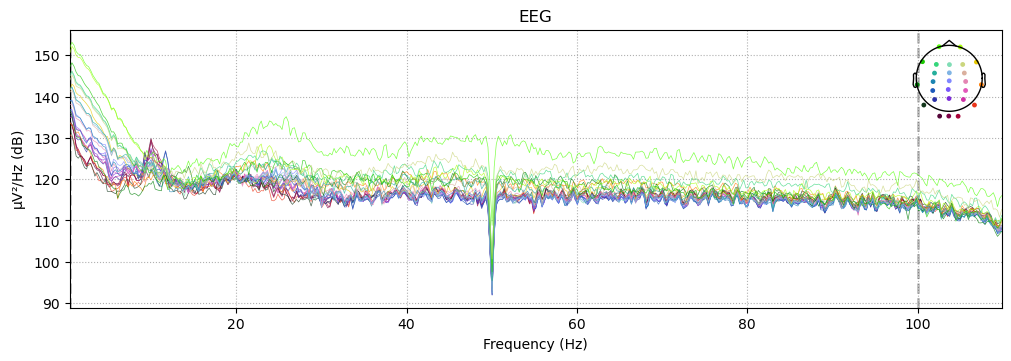

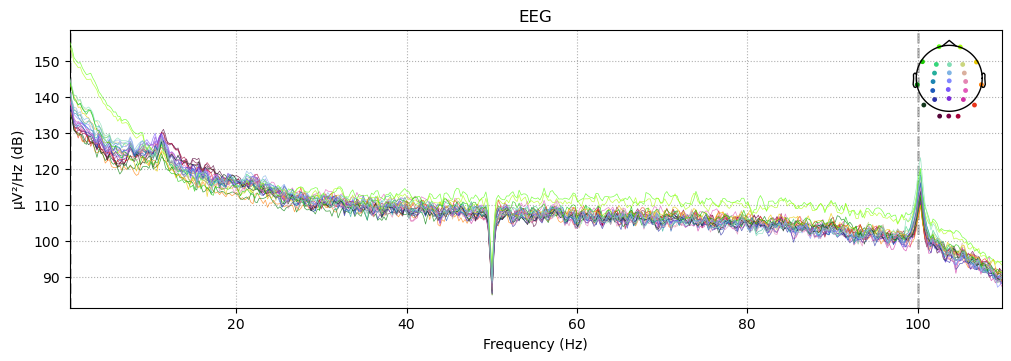

In [141]:
# pickle file keeps data correctly
psd_ec_1.plot(picks='data', exclude='bads')
psd_ec_2.plot(picks='data', exclude='bads')
psd_eo_1.plot(picks='data', exclude='bads')
psd_eo_2.plot(picks='data', exclude='bads')
;

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


''

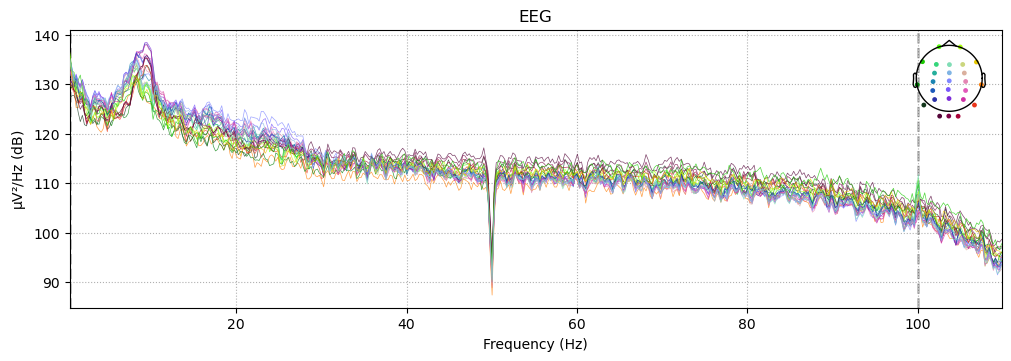

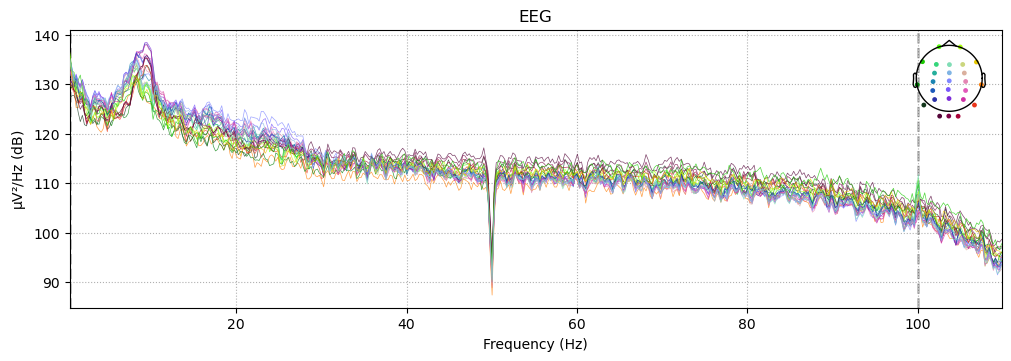

In [139]:
# check if the right PSD is stored for the right participant (sub-88078657, session 1, EC)
# first calculate PSD of participant without storing in df
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
psd_before_pickle = epochs.compute_psd(method = 'welch', fmin = 0.25, fmax = 110, picks = 'eeg', average = 'mean') # not sure which fmin and fmax to use?

# next obtain calculated PSD of participant stored in df
psd_after_pickle = df_after_pickle.loc[((df_par['participants_ID']=='sub-88078657') & (df_par['sessID'] == 1)), 'EC_PSD'].values[0]

#arr1 = psd_before_pickle.get_data(return_freqs=True)
#arr2 = psd_after_pickle.get_data(return_freqs=True)
#print(arr1, '\n', '====================', '\n', arr2)

psd_before_pickle.plot(picks='data', exclude='bads')
psd_after_pickle.plot(picks='data', exclude='bads')
;

In [140]:
psd_after_pickle # data is preserved

Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,12
Dims,"epoch, channel, freq"
Estimation method,welch
Number of channels,26
Number of frequency bins,449
Frequency range,0.49 – 109.86 Hz


# Time-frequency analysis

First for singular participant to determine workflow:

In [8]:
df_par = pd.read_pickle('participants_PSD.pkl')
df_par.head(3)

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD
0,sub-19681349,REPLICATION,REPLICATION,REPLICATION,REPLICATION,51.59,0,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1,sub-19681385,REPLICATION,REPLICATION,REPLICATION,REPLICATION,49.96,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
2,sub-19684666,REPLICATION,REPLICATION,REPLICATION,REPLICATION,47.05,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."


In [8]:
# load data and create epochs
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
print(epochs)

<Epochs |  12 events (good & bad), 0 – 9.998 s, baseline off, ~40 kB, data not loaded,
 '1': 12>


### Morlet wave convolution

In [62]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.logspace(*np.log10([0.5, 35]), num=8) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power, itc= tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 0.5       ,  0.91739304,  1.68321996,  3.08834854,  5.66645888,
       10.39673982, 19.0757934 , 35.        ])


In [12]:
print(epochsTFR) # TFR for each epoch seperate
print(power) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], epochs : 12, channels : 26, ~95.2 MB>
<AverageTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], nave : 12, channels : 26, ~8.0 MB>


### Multitaper method

In [97]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.logspace(*np.log10([0.5, 35]), num=8) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt= tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 0.5       ,  0.91739304,  1.68321996,  3.08834854,  5.66645888,
       10.39673982, 19.0757934 , 35.        ])


In [98]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], epochs : 12, channels : 26, ~95.2 MB>
<AverageTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], nave : 12, channels : 26, ~8.0 MB>


### Comparing Morlet vs Multitaper

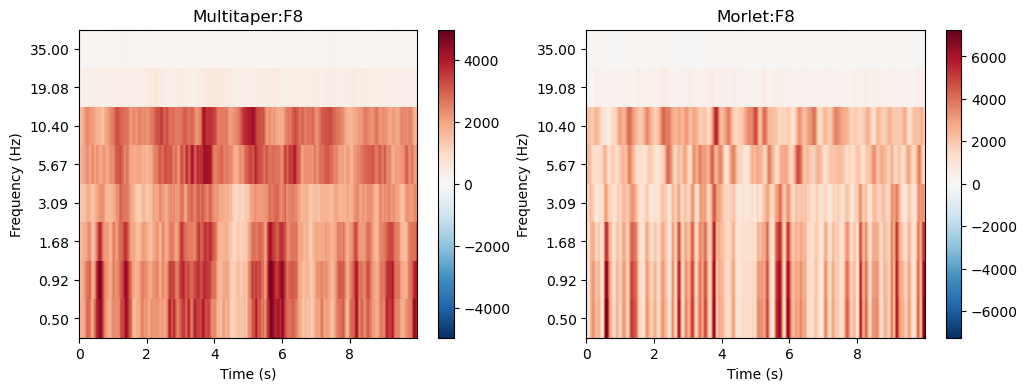

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

power_mt.plot([6], axes=ax1, show=False)
power.plot([6], axes=ax2, show=False)
ax1.set_title(f'Multitaper:{ch_names[6]}')
ax2.set_title(f'Morlet:{ch_names[6]}')
plt.show()

Text(0.5, 0.98, 'Morlet')

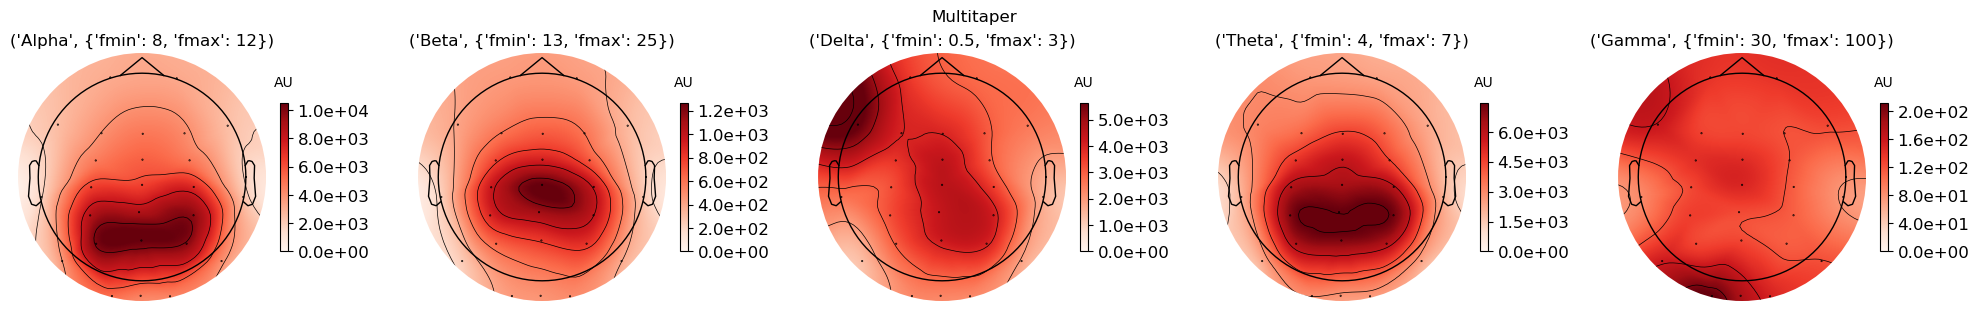

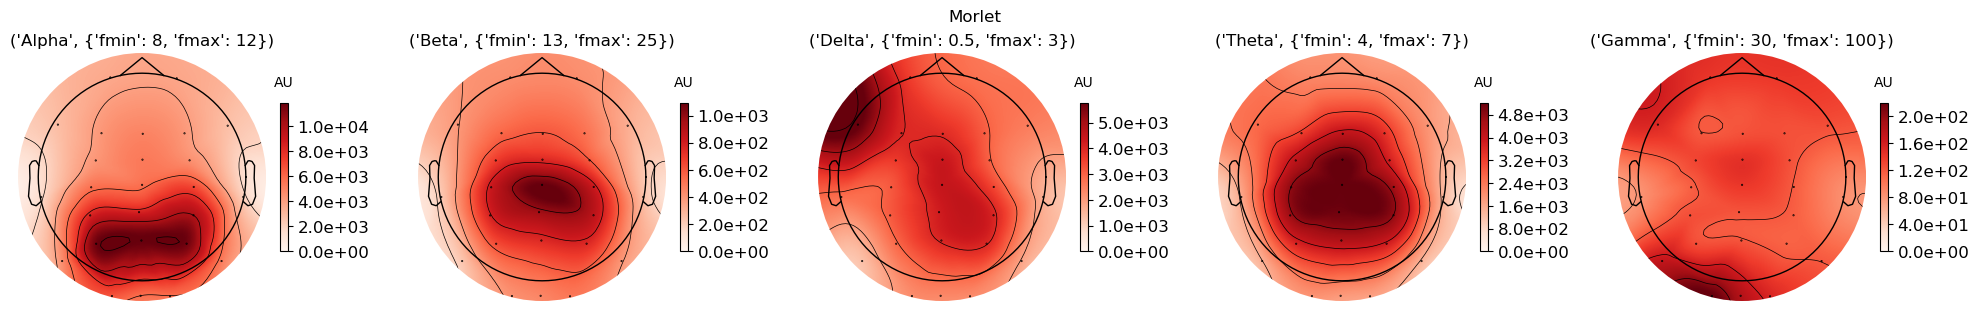

In [100]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power_mt.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Multitaper')

fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Morlet')


### Now, use the workflow for a single participant to create loop for all participants 

In [109]:
# add empty columns to the dataframe for EC/EO conditions in which the PSDs can be stored
df_par['EC_TFR_Morlet'] = np.nan
df_par['EO_TFR_Morlet'] = np.nan
df_par['EC_TFR_MT'] = np.nan
df_par['EO_TFR_MT'] = np.nan

# set variable to 'object' type to ensure correct storing of MNE objects
df_par['EC_TFR_Morlet'] = df_par['EC_TFR_Morlet'].astype('object')
df_par['EO_TFR_Morlet'] = df_par['EO_TFR_Morlet'].astype('object')
df_par['EC_TFR_MT'] = df_par['EC_TFR_MT'].astype('object')
df_par['EO_TFR_MT'] = df_par['EO_TFR_MT'].astype('object')

df_par.head(3)

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD,EC_TFR_Morlet,EO_TFR_Morlet,EC_TFR_MT,EO_TFR_MT
0,sub-19681349,REPLICATION,REPLICATION,REPLICATION,REPLICATION,51.59,0,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ...",NaN,NaN,NaN,NaN
1,sub-19681385,REPLICATION,REPLICATION,REPLICATION,REPLICATION,49.96,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ...",NaN,NaN,NaN,NaN
2,sub-19684666,REPLICATION,REPLICATION,REPLICATION,REPLICATION,47.05,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ...",NaN,NaN,NaN,NaN


In [110]:
# calculate PSD for each EEG data .csv file and store in dataframe corresponding to participant and EC/EO condition

# define frequencies of interest (log-spaced) (just random for now)
freqs = np.logspace(*np.log10([0.5, 35]), num=8) 
n_cycles = freqs / 2.0 # different number of cycles per frequency

eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"
for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        #print(os.path.join(subdir, file))
        filepath = os.path.join(subdir, file)
        eeg_data = pd.read_csv(filepath, sep=',')
        eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

        raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
        raw.notch_filter(50)
        raw.filter(0.5, 100)
        #raw.info

        # epoch the data and compute PSD
        epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
        
        # perform Time-frequency analysis using Morlet wave convolution
        power_morlet = tfr_morlet(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            use_fft=True,
            return_itc=False,
            average=True,
            decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)

        # perform Time-frequency analysis using the Multitaper method
        power_mt = tfr_multitaper(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=True,
            decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=-1)
        
        
        # split file name to obtain ID and session number
        ID = str(file.split('_')[0])
        #print(ID)
        sessID = int(file.split('_')[1].split('-')[1])
        #print(sessID)
        
        # add TFR objects to dataframe
        if 'EC' in file:
            df_par['EC_TFR_Morlet'] = df_par['EC_TFR_Morlet'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([power_morlet]*df_par.shape[0]))
            df_par['EC_TFR_MT'] = df_par['EC_TFR_MT'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([power_mt]*df_par.shape[0]))
        if 'EO' in file:
            df_par['EO_TFR_Morlet'] = df_par['EO_TFR_Morlet'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([power_morlet]*df_par.shape[0]))
            df_par['EO_TFR_MT'] = df_par['EO_TFR_MT'].mask((df_par['participants_ID']==ID) & (df_par['sessID'] == sessID),pd.Series([power_mt]*df_par.shape[0]))



df_par        

ParserError: Error tokenizing data. C error: out of memory

In [9]:
df_par.head(3)

,participants_ID,DISC/REP,indication,formal_status,Dataset,age,gender,sessID,nrSessions,EC,EO,EC_PSD,EO_PSD
0,sub-19681349,REPLICATION,REPLICATION,REPLICATION,REPLICATION,51.59,0,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
1,sub-19681385,REPLICATION,REPLICATION,REPLICATION,REPLICATION,49.96,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."
2,sub-19684666,REPLICATION,REPLICATION,REPLICATION,REPLICATION,47.05,1,1,1,True,True,"<Power Spectrum (from Epochs, welch method) | ...","<Power Spectrum (from Epochs, welch method) | ..."


### Check different ways of data storage

In [9]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.logspace(*np.log10([0.5, 35]), num=8) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

psd_epochs = epochs.compute_psd(
    method = 'welch', 
    fmin = 0.25, 
    fmax = 110, 
    picks = 'eeg', 
    average = 'mean')

freqs = array([ 0.5       ,  0.91739304,  1.68321996,  3.08834854,  5.66645888,
       10.39673982, 19.0757934 , 35.        ])


In [19]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs
print(psd_epochs)

<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], epochs : 12, channels : 26, ~95.2 MB>
<AverageTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], nave : 12, channels : 26, ~8.0 MB>
<Power Spectrum (from Epochs, welch method) | 12 epochs × 26 channels × 449 freqs, 0.5-109.9 Hz>


In [20]:
print(power_mt.data.shape) # shape (n_channels, n_freqs, n_times)
print(epochsTFR_mt.data.shape) # shape (n_epochs, n_channels, n_freqs, n_times)
print(psd_epochs.shape) # shape (n_epochs, n_channels, n_freqs)

(26, 8, 5000)
(12, 26, 8, 5000)
(12, 26, 449)


In [21]:
# try storing the MNE TFR object in numpy arrays
a = np.array(power_mt) # storing as object
b = np.array(power_mt)
c = np.append(a, b)
c[0].info # data is correctly stored and retrieved from object in numpy array

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,26 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [28]:
# try storing the MNE TFR object in numpy array with participant ID, sessID, and EC/EO
ID = 89123819
sessID = 1
a = np.array([ID, sessID, 1, power_mt])
print(a.shape)
print(a)


(4,)
[89123819 1 1
 <AverageTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], nave : 12, channels : 26, ~8.0 MB>]


In [23]:
# doesnt work for Power Spectrum object for some reason. I think becuase the Power Spectrum object is already a sort of array (?)
a = np.array(psd_epochs) # storing as object
b = np.array(psd_epochs)
c = np.append(a, b, axis=0)
print(a.shape)
print(b.shape)
print(c.shape)

(12, 26, 449)
(12, 26, 449)
(24, 26, 449)


In [24]:
# doesnt work for Power Spectrum object for some reason. I think becuase the Power Spectrum object is already a sort of array (?)
ID = 89123819
sessID = 1
a = np.array([ID, sessID, 1, psd_epochs])
a

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [27]:
a = np.array(psd_epochs)
b = np.expand_dims(a, axis=0)
b.shape


(1, 12, 26, 449)

In [10]:
# calculate PSD & TFR for each EEG data .csv file and store in numpy array

# define frequencies of interest (log-spaced) (just random for now)
freqs = np.logspace(*np.log10([0.5, 35]), num=8) 
n_cycles = freqs / 2.0 # different number of cycles per frequency
eeg_array = np.array([])

eeg_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives"
for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
    for file in files:
        #print(os.path.join(subdir, file))
        filepath = os.path.join(subdir, file)
        eeg_data = pd.read_csv(filepath, sep=',')
        eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

        raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
        raw.notch_filter(50)
        raw.filter(0.5, 100)
        #raw.info

        # epoch the data and compute PSD
        epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?

        # calculate PSD using Welch's method
        #psd_epochs = epochs.compute_psd(method = 'welch', fmin = 0.25, fmax = 110, picks = 'eeg', average = 'mean') # not sure which fmin and fmax to use?
        
        # perform Time-frequency analysis using Morlet wave convolution
        power_morlet = tfr_morlet(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            use_fft=True,
            return_itc=False,
            average=True,
            decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=None)

        # perform Time-frequency analysis using the Multitaper method
        power_mt = tfr_multitaper(
            epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            time_bandwidth=4, # just random for now
            use_fft=True,
            return_itc=False,
            average=True,
            decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
            n_jobs=None)
        
        
        # split file name to obtain ID and session number
        ID = int(file.split('_')[0].split('-')[1])
        #print(ID)
        sessID = int(file.split('_')[1].split('-')[1])
        #print(sessID)
        
        # add TFR objects to dataframe
        if 'EC' in file:
            #eeg_array = np.append(eeg_array, np.array([ID, sessID, 0, 2, psd_epochs])) # array [participant_ID, session ID, EC/EO (0/1), feature type (PSD, Morlet TFR, Multitaper TFR (2/0/1)), MNE object]
            eeg_array = np.append(eeg_array, np.array([ID, sessID, 0, 0, power_morlet]))
            eeg_array = np.append(eeg_array, np.array([ID, sessID, 0, 1, power_mt]))
        if 'EO' in file:
           #eeg_array = np.append(eeg_array, np.array([ID, sessID, 1, 2, psd_epochs]))
           eeg_array = np.append(eeg_array, np.array([ID, sessID, 1, 0, power_morlet]))
           eeg_array = np.append(eeg_array, np.array([ID, sessID, 1, 1, power_mt]))

eeg_array.shape

ParserError: Error tokenizing data. C error: out of memory

Problem: Not enough memory

Would it be more efficient if stored in multidimensional array instead of current onedimensional array? Problem: don't I need the actual participant_ID? As some participants have missing files, so order isn't entirely the same

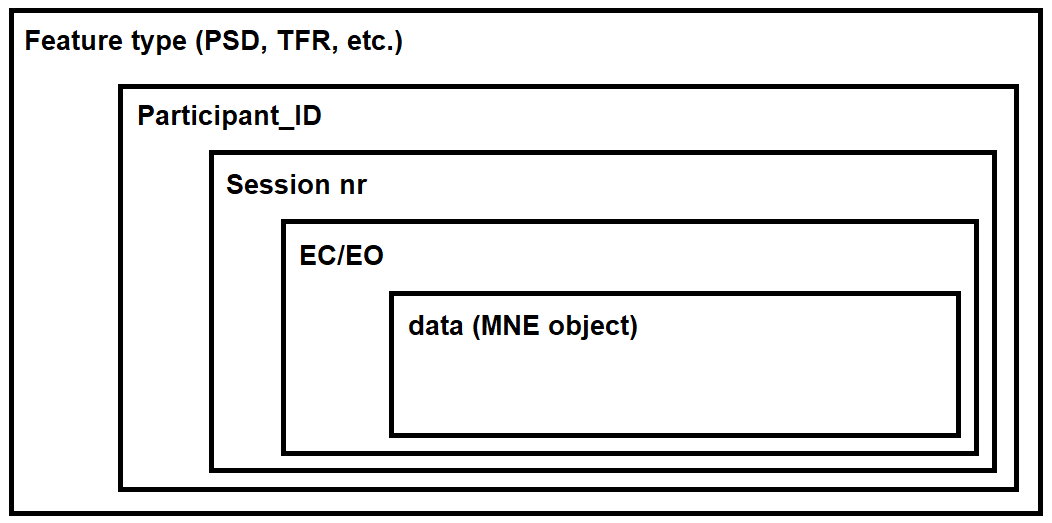

Or store features in seperate files? Problem: Memory will still be an issue when loading all features for classification?